<a href="https://colab.research.google.com/github/chefdarek/DS-Unit-2-Classification-1/blob/master/module2-decision-trees/Decision_trees_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
!pip install category_encoders
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import category_encoders as ce



train_features = pd.read_csv('https://drive.google.com/uc?export=download&id=14ULvX0uOgftTB2s97uS8lIx1nHGQIB0P')
train_labels = pd.read_csv('https://drive.google.com/uc?export=download&id=1r441wLr7gKGHGLyPpKauvCuUOU556S2f')
test_features = pd.read_csv('https://drive.google.com/uc?export=download&id=1wvsYl9hbRbZuIuoaLWCsW_kbcxCdocHz')
sample_submission = pd.read_csv('https://drive.google.com/uc?export=download&id=1kfJewnmhowpUo381oSn3XqsQ6Eto23XV')
train_features.shape, train_labels.shape, test_features.shape, sample_submission.shape

((59400, 40), (59400, 2), (14358, 40), (14358, 2))

In [2]:
train_features.shape

(59400, 40)

In [0]:
def missing_values(data):
   total = data.isnull().sum()
   percent = data.isnull().sum().sort_values(ascending = False)/len(data)*100
   tp = pd.concat([total, percent], axis=1, keys=['Total', '%'], sort=False)
   return(np.transpose(tp))

In [4]:
missing_values(train_features)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
Total,0.0,0.0,0.0,3635.000000,0.0,3655.000000,0.0,0.0,0.0,0.0,0.0,371.000000,0.0,0.0,0.0,0.0,0.0,0.0,3334.000000,0.0,3877.000000,28166.000000,3056.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%,0.0,0.0,0.0,6.119529,0.0,6.153199,0.0,0.0,0.0,0.0,0.0,0.624579,0.0,0.0,0.0,0.0,0.0,0.0,5.612795,0.0,6.526936,47.417508,5.144781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 
                       'longitude', 
                       'latitude','num_private',
                       'population',
                      
]
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X

- `amount_tsh` : Total static head (amount water available to waterpoint)
- `date_recorded` : The date the row was entered
- `funder` : Who funded the well
- `gps_height` : Altitude of the well
- `installer` : Organization that installed the well
- `longitude` : GPS coordinate
- `latitude` : GPS coordinate
- `wpt_name` : Name of the waterpoint if there is one
- `num_private` :  
- `basin` : Geographic water basin
- `subvillage` : Geographic location
- `region` : Geographic location
- `region_code` : Geographic location (coded)
- `district_code` : Geographic location (coded)
- `lga` : Geographic location
- `ward` : Geographic location
- `population` : Population around the well
- `public_meeting` : True/False
- `recorded_by` : Group entering this row of data
- `scheme_management` : Who operates the waterpoint
- `scheme_name` : Who operates the waterpoint
- `permit` : If the waterpoint is permitted
- `construction_year` : Year the waterpoint was constructed
- `extraction_type` : The kind of extraction the waterpoint uses
- `extraction_type_group` : The kind of extraction the waterpoint uses
- `extraction_type_class` : The kind of extraction the waterpoint uses
- `management` : How the waterpoint is managed
- `management_group` : How the waterpoint is managed
- `payment` : What the water costs
- `payment_type` : What the water costs
- `water_quality` : The quality of the water
- `quality_group` : The quality of the water
- `quantity` : The quantity of water
- `quantity_group` : The quantity of water
- `source` : The source of the water
- `source_type` : The source of the water
- `source_class` : The source of the water
- `waterpoint_type` : The kind of waterpoint
- `waterpoint_type_group` : The kind of waterpoint

In [6]:
X_train = train_features
y_train = train_labels['status_group']

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.80, test_size=0.20, 
    stratify=y_train, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [7]:
X_train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,47520,1,GeoData Consultants Ltd,47520
public_meeting,44876,2,True,40838
permit,45077,2,True,31071
source_class,47520,3,groundwater,36638
management_group,47520,5,user-group,42027
quantity_group,47520,5,enough,26567
quantity,47520,5,enough,26567
waterpoint_type_group,47520,6,communal standpipe,27642
quality_group,47520,6,good,40598
payment_type,47520,7,never pay,20287


In [0]:
W_train= wrangle(X_train)
W_val= wrangle(X_val)
W_test = wrangle(test_features)

In [0]:
W_train = W_train.drop(['longitude','date_recorded',
                        'latitude','funder', 'recorded_by'], axis=1)
W_val = W_val.drop(['longitude','date_recorded',
                        'latitude','funder', 'recorded_by'], axis=1)
W_test = W_test.drop(['longitude','date_recorded',
                        'latitude','funder', 'recorded_by'], axis=1)


In [0]:
for x in W_val.columns:
  print(x)
  print(W_val[x].value_counts().T)

In [11]:
X_train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,47520,1,GeoData Consultants Ltd,47520
public_meeting,44876,2,True,40838
permit,45077,2,True,31071
source_class,47520,3,groundwater,36638
management_group,47520,5,user-group,42027
quantity_group,47520,5,enough,26567
quantity,47520,5,enough,26567
waterpoint_type_group,47520,6,communal standpipe,27642
quality_group,47520,6,good,40598
payment_type,47520,7,never pay,20287


In [0]:
categorical_features = [
  'management_group', 'payment_type', 'source_class', 
  'quality_group', 'quantity', 'waterpoint_type_group', 
  'extraction_type_group', 'basin', 'source', 'region', 
  'public_meeting', 'permit', 'installer', 'ward']

numeric_features = W_train.select_dtypes('number').columns.drop('id').tolist()
features = categorical_features + numeric_features

In [0]:
W_train_subset = W_train[features]
W_val_subset = W_val[features]
W_test_subset = W_test[features]

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
W_train_encoded = encoder.fit_transform(W_train_subset)
W_val_encoded = encoder.transform(W_val_subset)
W_test_encoded = encoder.transform(W_test_subset)

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, max_depth=15)
dt.fit(W_train_encoded, y_train)
print('Decision Tree')
print('Train Accuracy', dt.score(W_train_encoded, y_train))
print('Validation Accuracy', dt.score(W_val_encoded, y_val))

Decision Tree
Train Accuracy 0.8038930976430977
Validation Accuracy 0.7648148148148148


In [0]:
y_pred = dt.predict(W_test_encoded)

In [36]:
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [37]:
sample_submission.head(3)

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional


In [38]:
print(W_train.shape)
W_train[:1]

(47520, 35)


,id,amount_tsh,gps_height,installer,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded
43360,72938,0.0,0,MISSING,Kwa Mzee Noa,38.608844,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,280.566034,True,VWC,K,MISSING,1996.825469,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2011


In [39]:
print(W_train_encoded.shape)
W_train_encoded[:1]

(47520, 4111)


,management_group_user-group,management_group_commercial,management_group_parastatal,management_group_unknown,management_group_other,payment_type_never pay,payment_type_monthly,payment_type_per bucket,payment_type_unknown,payment_type_annually,payment_type_on failure,payment_type_other,source_class_groundwater,source_class_surface,source_class_unknown,quality_group_good,quality_group_salty,quality_group_fluoride,quality_group_milky,quality_group_unknown,quality_group_colored,quantity_insufficient,quantity_enough,quantity_dry,quantity_seasonal,quantity_unknown,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_other,waterpoint_type_group_improved spring,waterpoint_type_group_cattle trough,waterpoint_type_group_dam,extraction_type_group_gravity,extraction_type_group_india mark ii,extraction_type_group_other,extraction_type_group_mono,extraction_type_group_swn 80,extraction_type_group_submersible,extraction_type_group_nira/tanira,extraction_type_group_other handpump,...,ward_Vumilia,ward_Masukulu,ward_Manyondwe,ward_Mkwajuni,ward_Makutopora,ward_Nyamtinga,ward_Kainam,ward_Jibondo,ward_Magoroto,ward_Mwembesongo,ward_Uyui,ward_Kining'inila,ward_Ukata,ward_Nsemulwa,ward_Misunkumilo,ward_Nditi,ward_Luwalaje,ward_Kapilula,ward_Matui,ward_Machinjioni,ward_Kapalala,ward_Lutindi,ward_Thawi,ward_Mawenzi,ward_Gidahababieg,ward_Levolosi,ward_Mkumbi,ward_Mwisi,ward_Matarawe,ward_Gongoni,ward_Lizaboni,ward_Mkwiti,amount_tsh,gps_height,num_private,region_code,district_code,population,construction_year,year_recorded
43360,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,38.608844,12,4,280.566034,1996.825469,2011


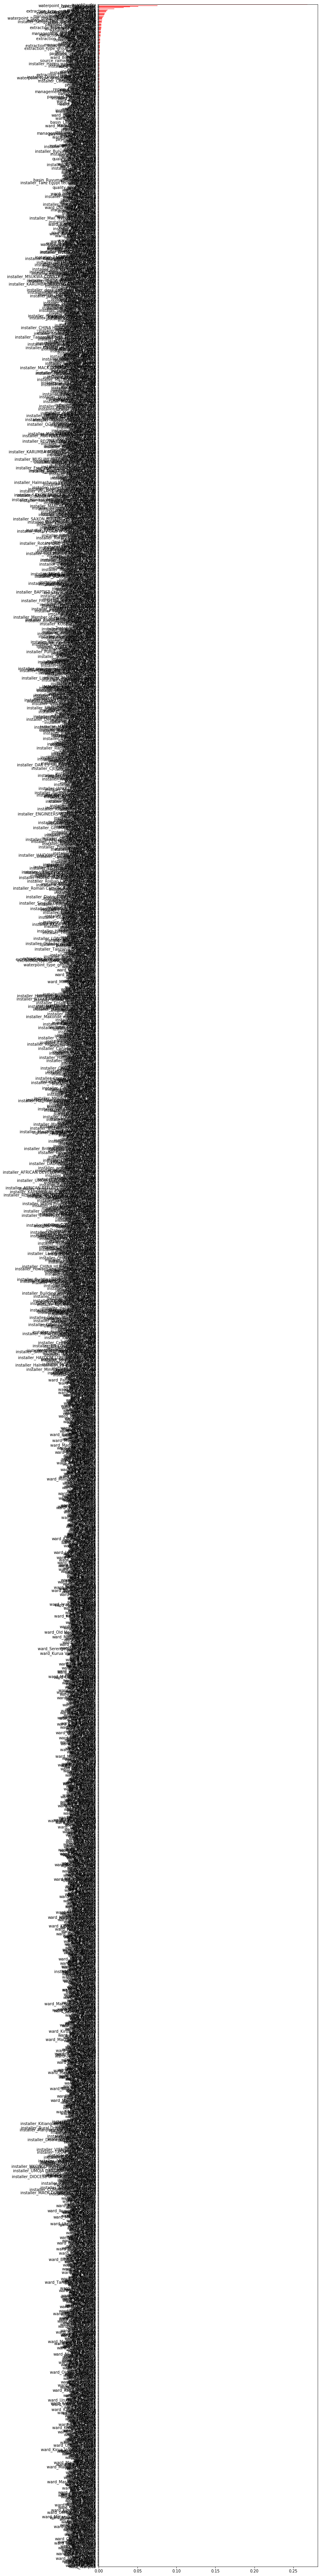

In [56]:
importances = pd.Series(dt.feature_importances_, 
                        W_train_encoded.columns)

plt.figure(figsize=(10,120))
#plt.yticks((np.arange(0, 1, step=0.2))
ax = importances.sort_values().plot.barh(color='red');

In [0]:
W_test_encoded

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Dareksubmission-02.csv', index=False)

In [0]:
submission.head()

In [42]:
model = RandomForestClassifier()
model.fit(W_train_encoded, y_train, criterion='gini',max_depth=15)
print('Random Forrest')
print('Train Accuracy', model.score(W_train_encoded, y_train))
print('Validation Accuracy', model.score(W_val_encoded, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forrest
Train Accuracy 0.9511153198653198
Validation Accuracy 0.7927609427609428


In [0]:
y_pred = model.predict(W_test_encoded)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Dareksubmission-03.csv', index=False)

In [0]:
import xgboost as xgb

In [29]:
y_train.head()

43360        functional
7263         functional
2486         functional
313      non functional
52726        functional
Name: status_group, dtype: object

In [0]:
model2 = xgb.XGBClassifier()
model2.fit(W_train_encoded, y_train)
print(model)
# make predictions for test data
y_pred = model.predict(W_val_encoded)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [0]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))